# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
r"E:\CodeBasics\potato-disease-prediction\train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names

class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Visualize some of the images from our dataset

(32, 256, 256, 3)
[0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 2 1 0 1 0 0 1 2 0 1 0 0 0 0]


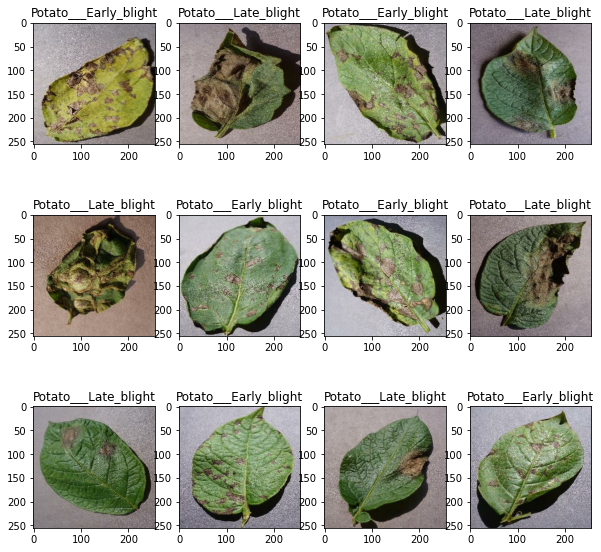

In [12]:
plt.figure(figsize = (10,10))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis = ('off')
        
    

In [13]:
len(dataset)

68

In [14]:
train_ds = dataset.take(54)   #80% dataset

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6)

In [22]:
len(test_ds)

8

### Function to Split Dataset

In [30]:
def get_dataset_partitions(ds,train_split =0.8,val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):
    
    assert(train_split + val_split + test_split) == 1
    
    ds_size = len(ds)
    
    
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12 )
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
        
        
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds , val_ds, test_ds = get_dataset_partitions(dataset)

In [32]:
len(train_ds)

54

In [33]:
len(val_ds)

6

In [35]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

In [40]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [41]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [42]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 178s 3s/step - loss: 0.9059 - accuracy: 0.4589 - val_loss: 0.8672 - val_accuracy: 0.6615
Epoch 2/50
54/54 [==============================] - 119s 2s/step - loss: 0.5986 - accuracy: 0.7188 - val_loss: 0.3752 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 137s 3s/step - loss: 0.3959 - accuracy: 0.8432 - val_loss: 0.3551 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 146s 3s/step - loss: 0.3146 - accuracy: 0.8738 - val_loss: 0.3357 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 134s 2s/step - loss: 0.2688 - accuracy: 0.8953 - val_loss: 0.2037 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 138s 3s/step - loss: 0.2218 - accuracy: 0.9057 - val_loss: 0.2279 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 135s 3s/step - loss: 0.2126 - accuracy: 0.9155 - val_loss: 0.3478 - val_accuracy: 0.8698
Epoch 8/50
54

In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 17s 551ms/step - loss: 0.1496 - accuracy: 0.9609


In [48]:
scores

[0.1495727002620697, 0.9609375]

### Plotting the Accuracy and Loss Curves

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

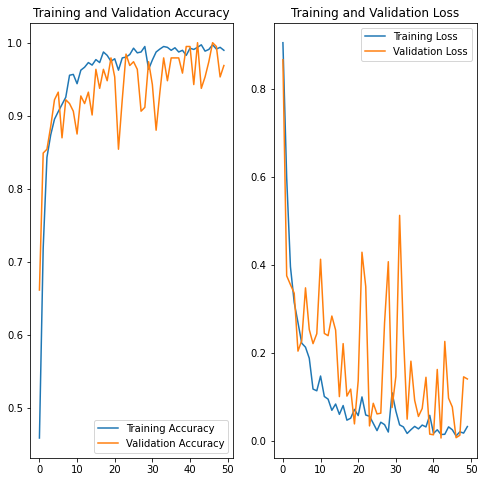

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 3s 3s/step
predicted label: Potato___Late_blight


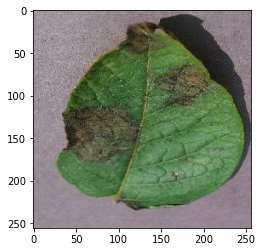

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Now run inference on few sample images

1/1 [==============================] - 0s 47ms/step


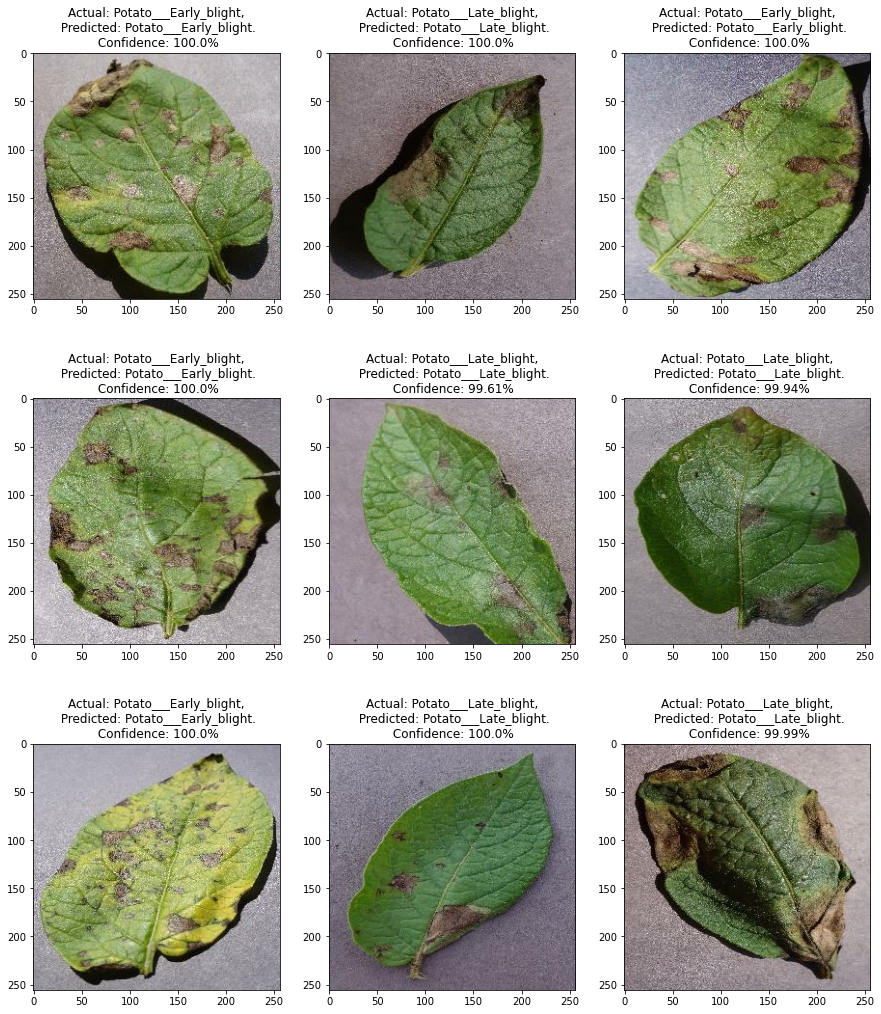

In [64]:
plt.figure(figsize=(15,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        

### Saving the Model

In [69]:
import os
model_version=max([int(i) for i in os.listdir("E:/CodeBasics/potato-disease-prediction/saved_models") + [0]])+1
model.save(f"E:/CodeBasics/potato-disease-prediction/saved_models/{model_version}")

INFO:tensorflow:Assets written to: E:/CodeBasics/potato-disease-prediction/saved_models/3\assets


INFO:tensorflow:Assets written to: E:/CodeBasics/potato-disease-prediction/saved_models/3\assets


In [68]:
model.save("E:/CodeBasics/potato-disease-prediction/potatoes.h5")